In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from scipy.optimize import minimize, rosen, rosen_der
np.set_printoptions(precision=3)
import pandas as P
P.set_option('display.precision',3)

In [2]:
NL_t = -0.4
NL_c = 0.01
NL_L = 1.8
NL_mu = 0.3

mass = 938.272045e6
ke = 2.5*1.0e6
energy = ke+mass
freq = 30*1.0e6

g = energy/mass
bg = np.sqrt(g**2-1.0)
vec = bg/g*impact.data.clight

alfaEntrance = np.tan(np.pi*NL_mu)
betaEntrance = NL_L/np.sin(2.0*np.pi*NL_mu)

In [3]:
print(alfaEntrance,betaEntrance)

1.3763819204711734 1.8926320036288808


# def subroutine 

In [4]:
def croot(z):
    return np.sqrt(1.0-z**2)

def carcsin(z):
    return -1j*np.log(1j*z+croot(z))

def Fpotential(x,y):
    zeta = x+1j*y
    return zeta/croot(zeta)*carcsin(zeta)

def Fderivative(x,y):
    zeta = x+1j*y
    denom = croot(zeta)
    return zeta/denom**2 + carcsin(zeta)/denom**3

def driftpropagator(x,px,y,py,ds):
    x= x+px*ds
    y= y+py*ds
    return x,px,y,py

def NLpropagator(x,px,y,py,ds):
    dF = Fderivative(x,y)
    px = px - x*ds + np.real(dF)*ds*NL_t
    if y==0.0:
        py = py - y*ds
    else:
        py = py - y*ds - np.imag(dF)*ds*NL_t
    return x,px,y,py


def InvariantPotentials(x,px,y,py):
    zeta = x+1j*y
    zetaconj = x-1j*y
    Hpotential = zeta/croot(zeta)
    Ipotential = (zeta+zetaconj)/croot(zeta)   
    Hpotential = Hpotential*carcsin(zeta)
    Ipotential = Ipotential*carcsin(zeta)
    Hinv = -NL_t*np.real(Hpotential) + 0.5*(x**2+px**2+y**2+py**2)
    Iinv = -NL_t*np.real(Ipotential) + (x*py - y*px)**2 + x**2 + px**2
    return Hinv,Iinv


def G(x,y):
    z = x+1j*y
    return np.imag(np.arcsin(z)/np.sqrt(1-z*z))

countP=0
countN=0
countO=0

def enforce_py_on_arc(x,px,y,py):
    global countP,countN,countO
    denom = x*x-1
    numer = px*x*y
    sq = (denom+px*px)*y*y+2*denom*y*NL_t*G(x,y)
    if sq>0:
        sq = np.sqrt(sq)
    else:
        countO=countO+1
        return py
    test0 = (numer+sq)/denom 
    test1 = (numer-sq)/denom 
    d0 = (test0 - py)**2
    d1 = (test1 - py)**2
    if np.max([d0,d1])>0.01:
        countO=countO+1
        return py
    if d0>d1:
        countN=countN+1
        return test1
    else:
        countP=countP+1
        return test0

    
def track(x,px,y,py,L,nSteps,mSample):
    n = int(nSteps)
    n_hidden = int(n/mSample)
    ds = L/n
    data = np.zeros((6,mSample+1))
    k=0
    for i in range(n):
        if k==mSample+1:
            break
        if np.mod(i,n_hidden)==0:
            data[:4,k] = x,px,y,py
            data[4:,k] = InvariantPotentials(x,px,y,py)
            k=k+1
        x,px,y,py = driftpropagator(x,px,y,py,0.5*ds)
        x,px,y,py = NLpropagator(x,px,y,py,ds)
        x,px,y,py = driftpropagator(x,px,y,py,0.5*ds)
        py = enforce_py_on_arc(x,px,y,py)
    data[:4,-1] = x,px,y,py
    data[4:,-1] = InvariantPotentials(x,px,y,py)
    return data

In [5]:
pdata=np.loadtxt('pOnArc.data')
npt = len(pdata)
pdata.shape

(18, 2)

(-1, 1)

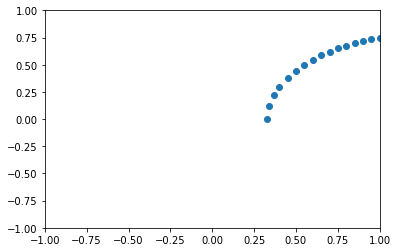

In [6]:
plt.scatter(pdata[:,0],pdata[:,1])
plt.xlim(-1,1)
plt.ylim(-1,1)

In [7]:
Inv0 = []
for i in range(npt):
    x = pdata[i,0]
    def enforce_py_on_arc0(y):
        denom = x*x-1
        sq = (denom)*y*y+2*denom*y*NL_t*G(x,y)
        return sq**2

    print(enforce_py_on_arc0(pdata[i,1]))
    res=minimize(enforce_py_on_arc0,pdata[i,1],tol=1e-12)
    print(res)
    y = res.x[0]
    pdata[i,1] = y
    H,I=InvariantPotentials(x,0,y,0)
    Inv0.append([H,I])

1.933325786409397e-21
      fun: array([1.933e-21])
 hess_inv: array([[1]])
      jac: array([-5.324e-18])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.003])
3.9766369491425914e-15
      fun: 1.7091278973510322e-24
 hess_inv: array([[35043.66]])
      jac: array([2.03e-13])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 3
     njev: 10
   status: 0
  success: True
        x: array([0.122])
1.6402581473189228e-14
      fun: 2.6664344587909427e-20
 hess_inv: array([[890.804]])
      jac: array([6.278e-13])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 2
     njev: 7
   status: 0
  success: True
        x: array([0.225])
9.252978024050651e-15
      fun: 1.4803522898268535e-19
 hess_inv: array([[187.338]])
      jac: array([1.702e-14])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
 

In [8]:
Lrad = 1024*2
data = [track(pdata[i,0], 0.0, pdata[i,1], 0.0,Lrad/(i+1),1024*1024,1024*1024)  for i in range(npt)]

In [24]:
Iradlist = [1024*1024]
for i in range(1,npt):
    for j in range(1024*256,1024*1024):
        if data[i][2,j] > 0.6*data[i][2,0]:
            break
    tmpj = int(0.999*j)
    j2=1024
    for k in range(10):
        j2 = j2*2
        if j2>tmpj:
            break
    Iradlist.append(int(j2/2))

In [28]:
dataBackup = copy(data)
for i in range(npt):
    data[i]=data[i][:,:Iradlist[i]]

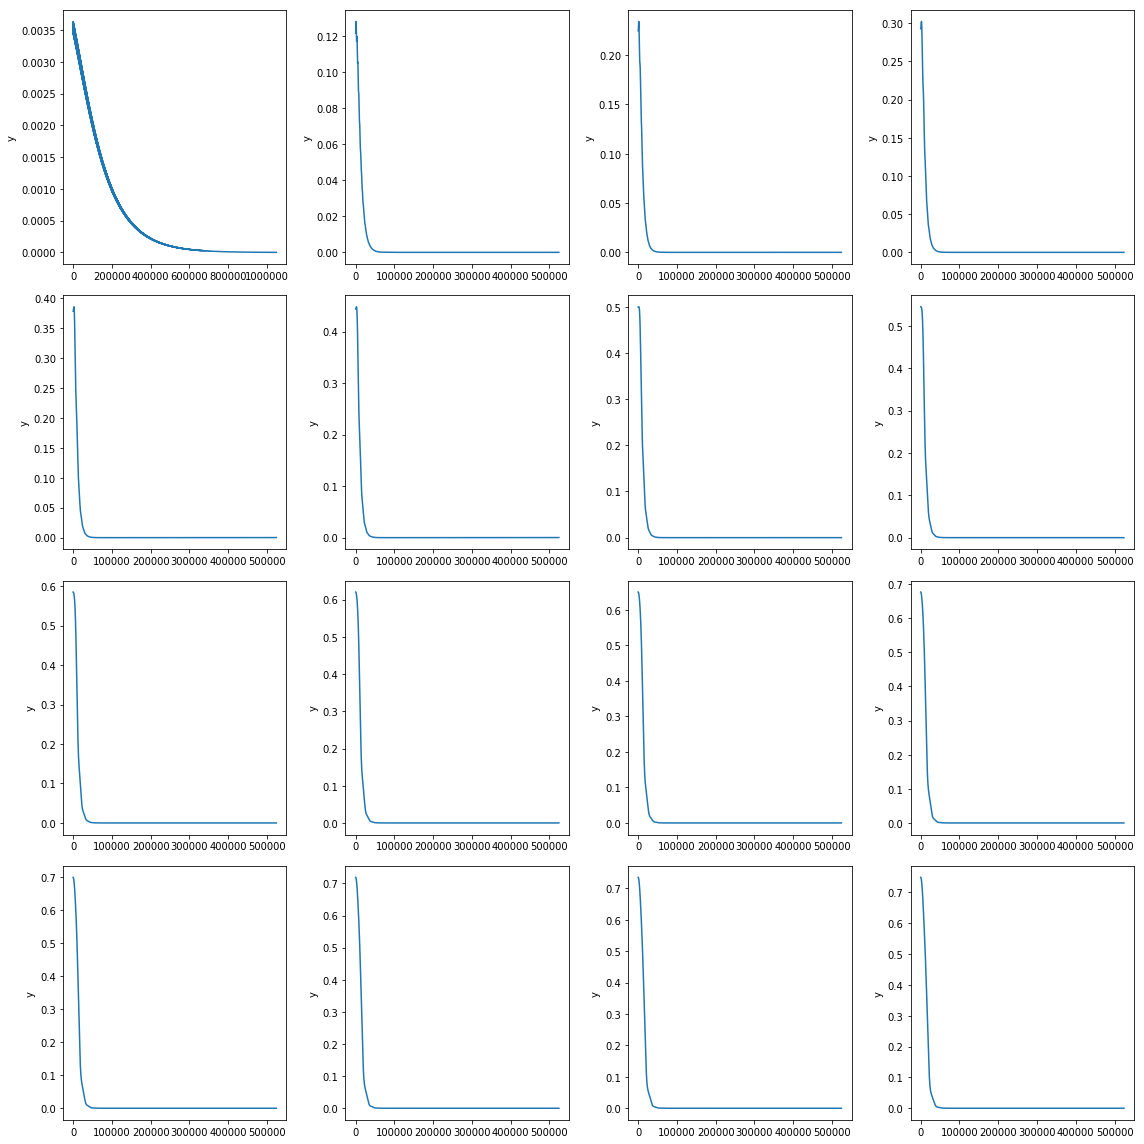

In [30]:
plt.figure(figsize=(16,16))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+i+1)
        plt.plot(data[4*j+i][2,:])
        plt.ylabel('y')
plt.tight_layout()

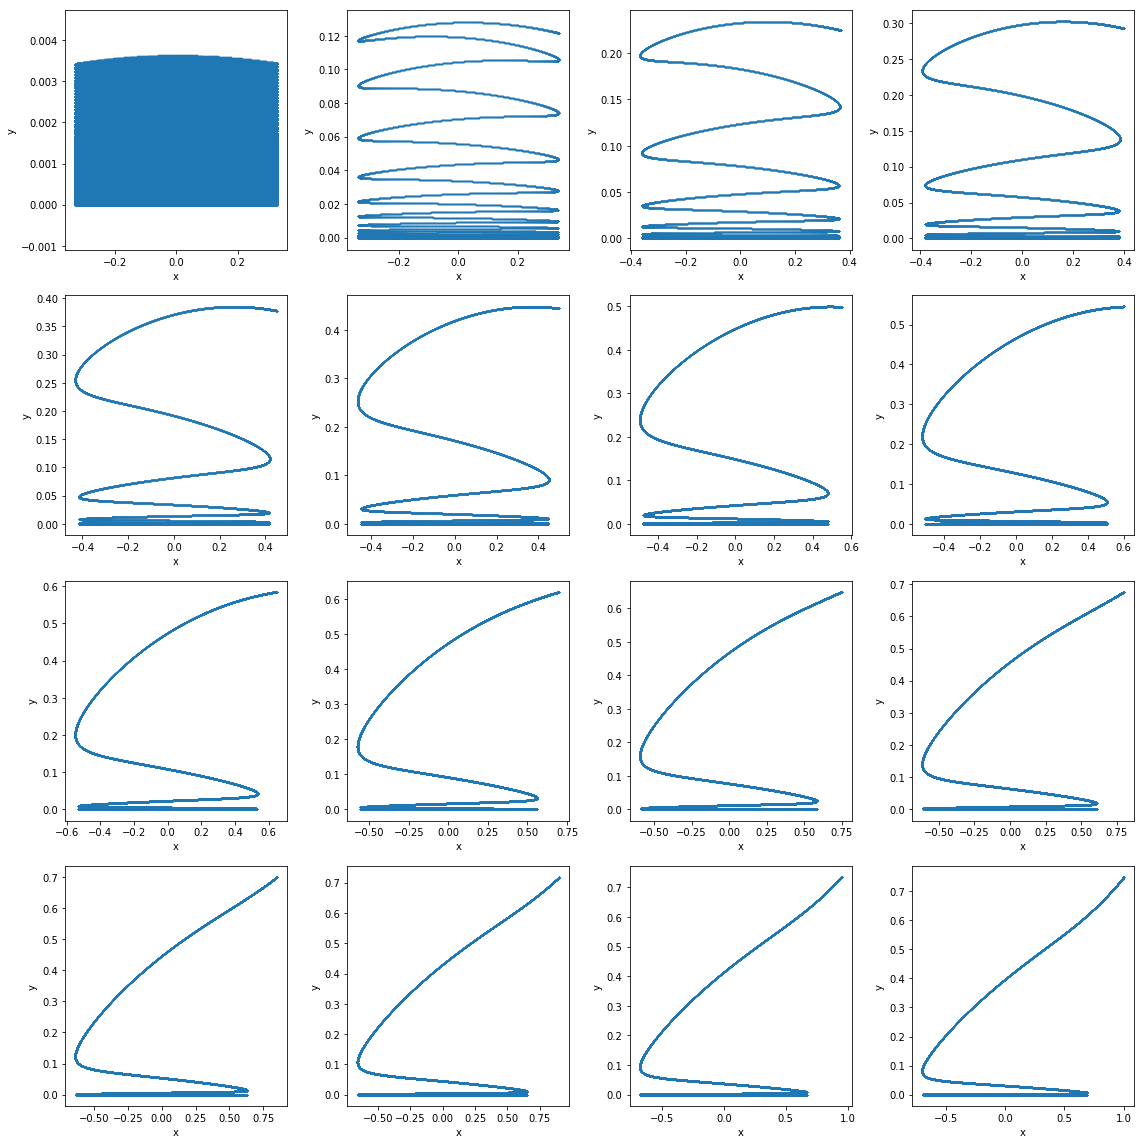

In [31]:
plt.figure(figsize=(16,16))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+i+1)
        plt.scatter(data[4*j+i][0,:],data[4*j+i][2,:],s=0.1)
        plt.xlabel('x')
        plt.ylabel('y')
plt.tight_layout()

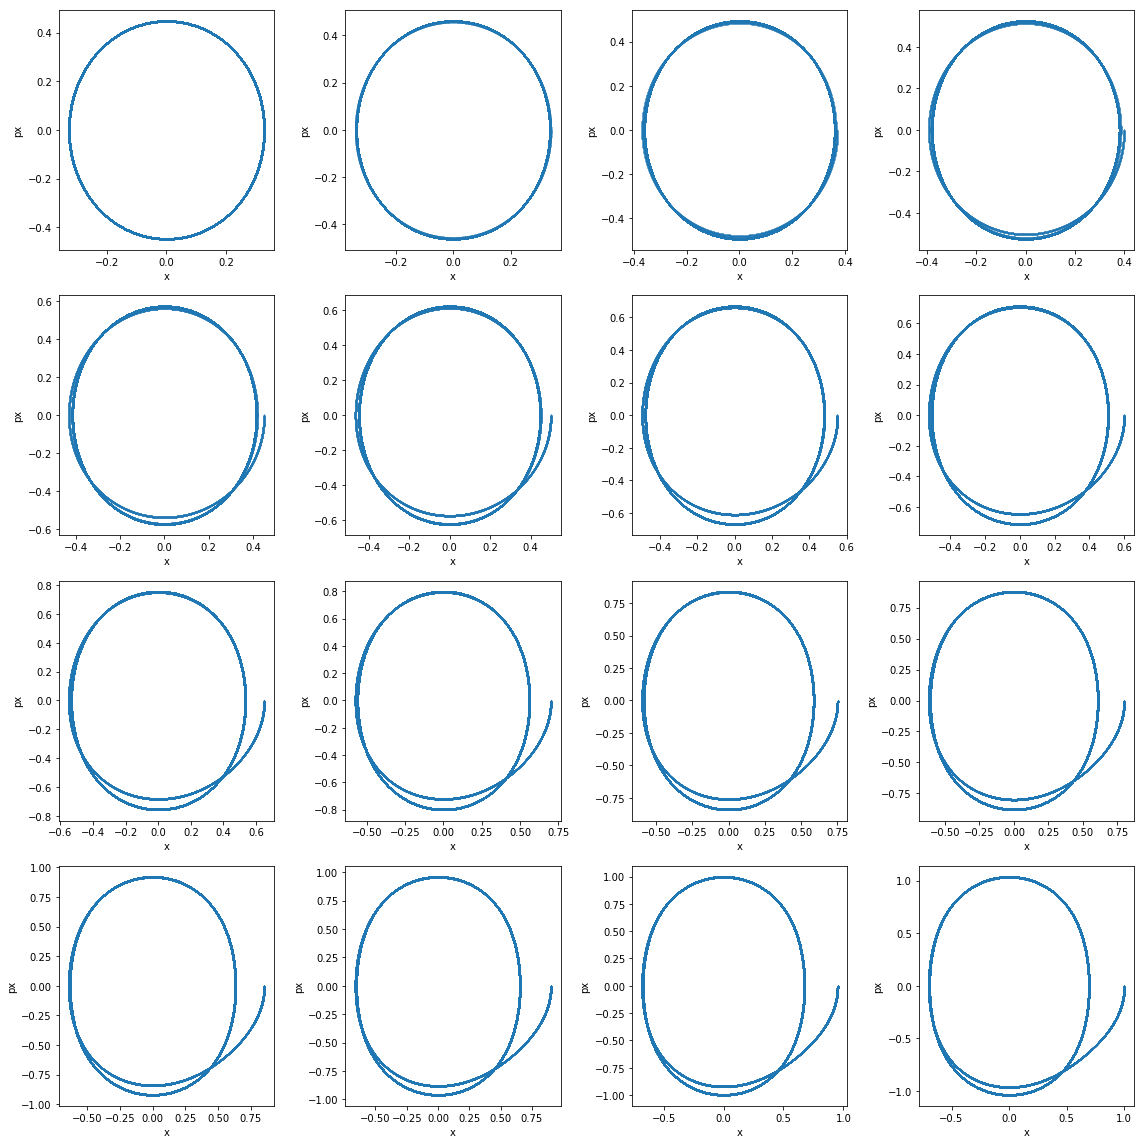

In [32]:
plt.figure(figsize=(16,16))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+i+1)
        plt.scatter(data[4*j+i][0,:],data[4*j+i][1,:],s=0.1)
        plt.xlabel('x')
        plt.ylabel('px')
plt.tight_layout()

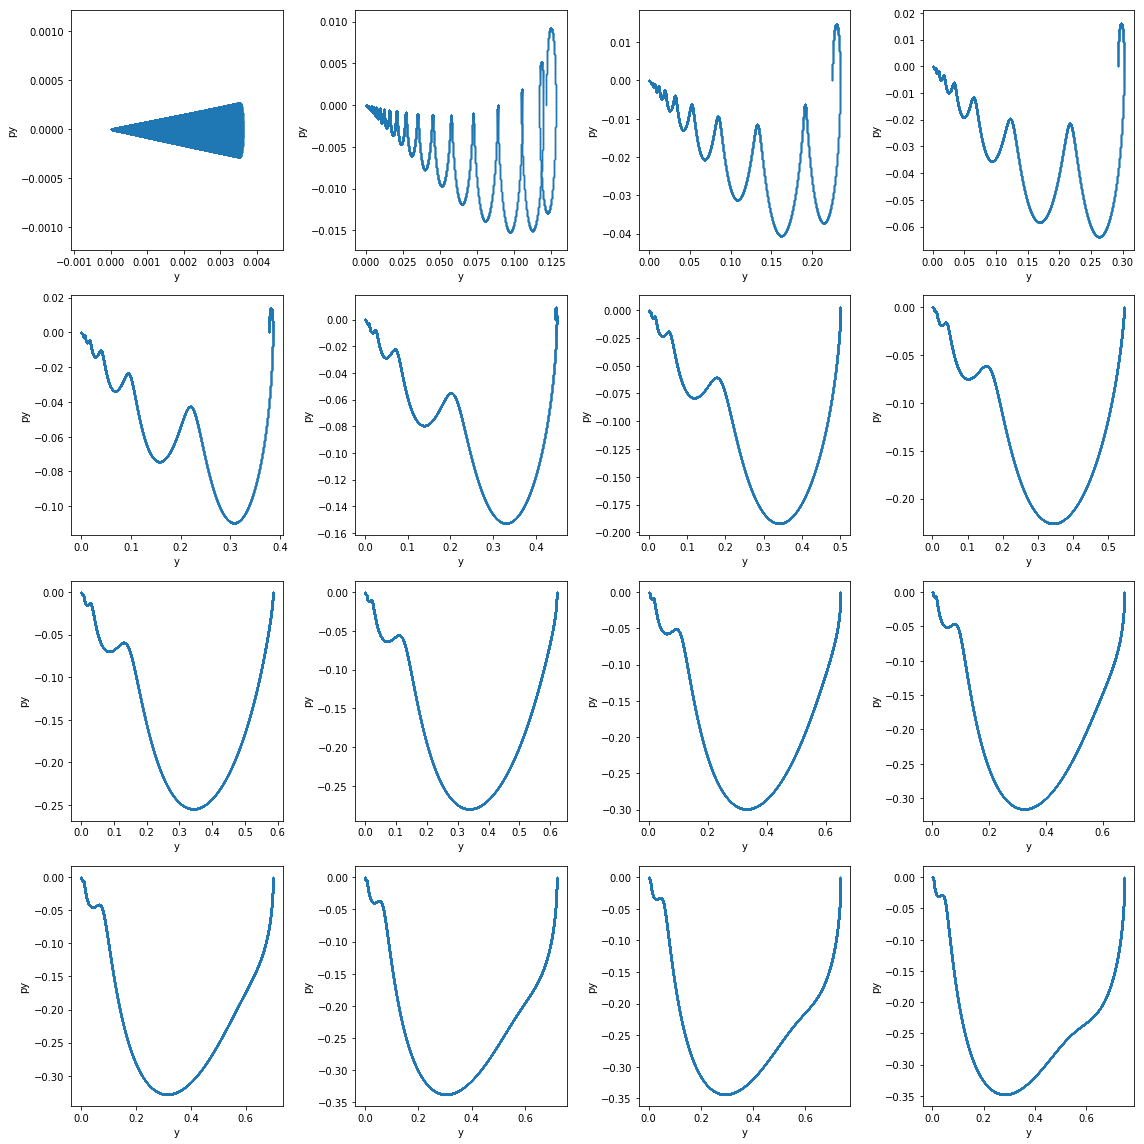

In [33]:
plt.figure(figsize=(16,16))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+i+1)
        plt.scatter(data[4*j+i][2,:],data[4*j+i][3,:],s=0.1)
        plt.xlabel('y')
        plt.ylabel('py')
plt.tight_layout()

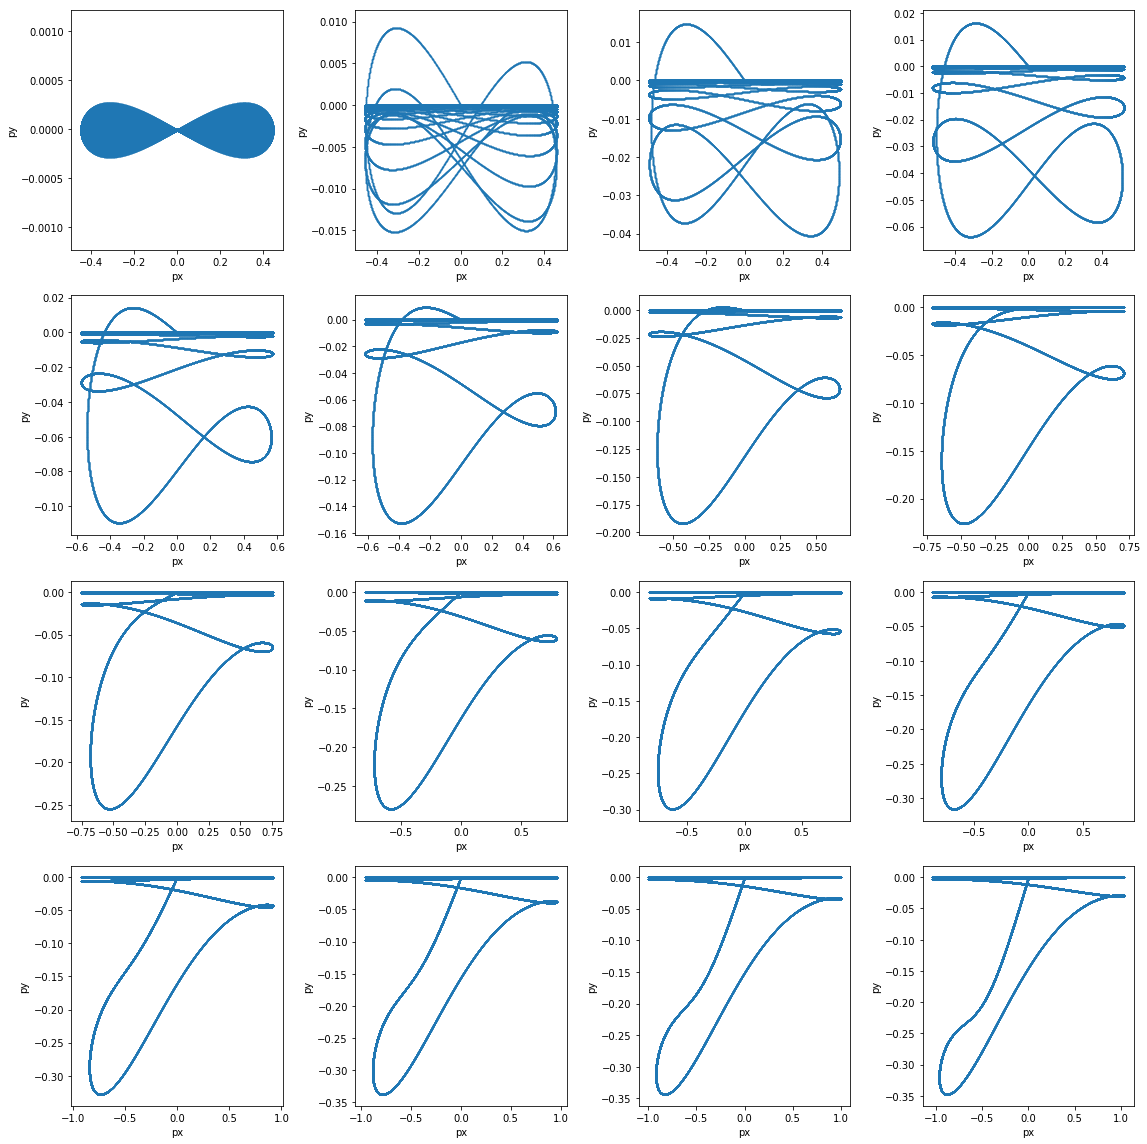

In [34]:
plt.figure(figsize=(16,16))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+i+1)
        plt.scatter(data[4*j+i][1,:],data[4*j+i][3,:],s=0.1)
        plt.xlabel('px')
        plt.ylabel('py')
plt.tight_layout()

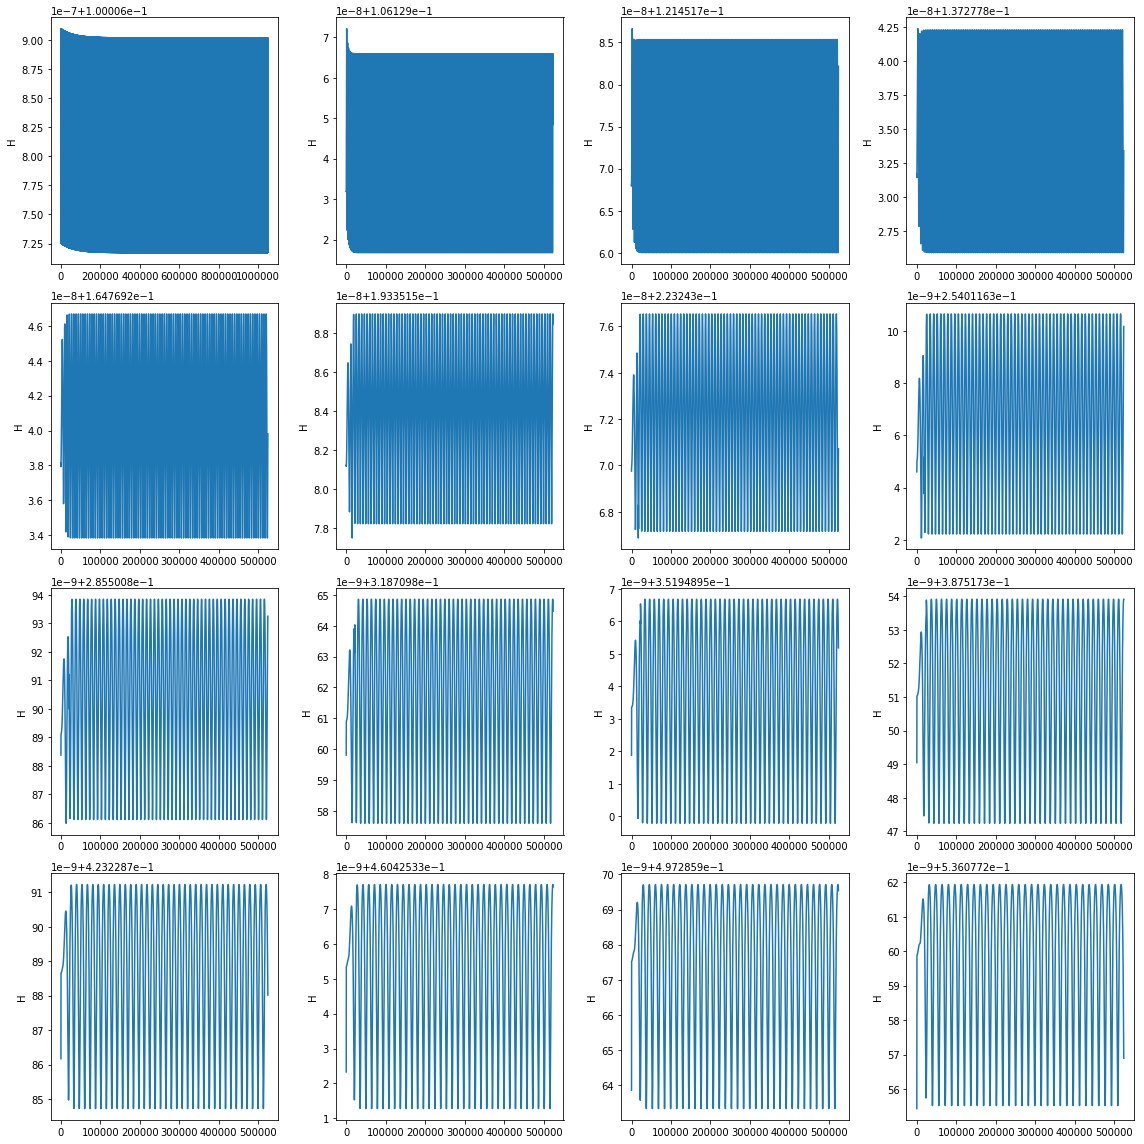

In [35]:
plt.figure(figsize=(16,16))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+i+1)
        plt.plot(data[4*j+i][4,:])
        plt.ylabel('H')
plt.tight_layout()

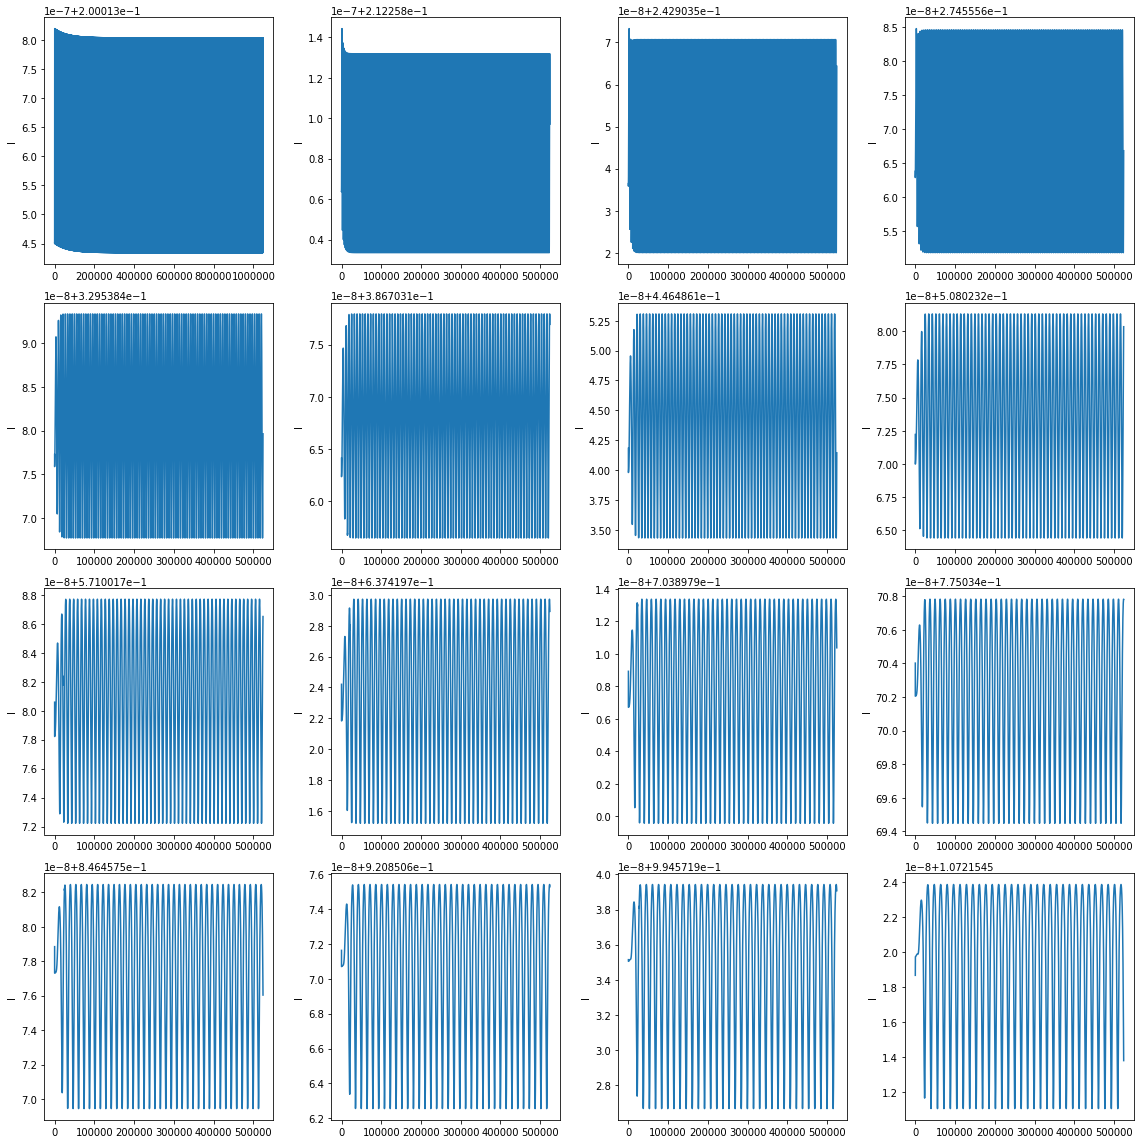

In [36]:
plt.figure(figsize=(16,16))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+i+1)
        plt.plot(data[4*j+i][5,:])
        plt.ylabel('I')
plt.tight_layout()

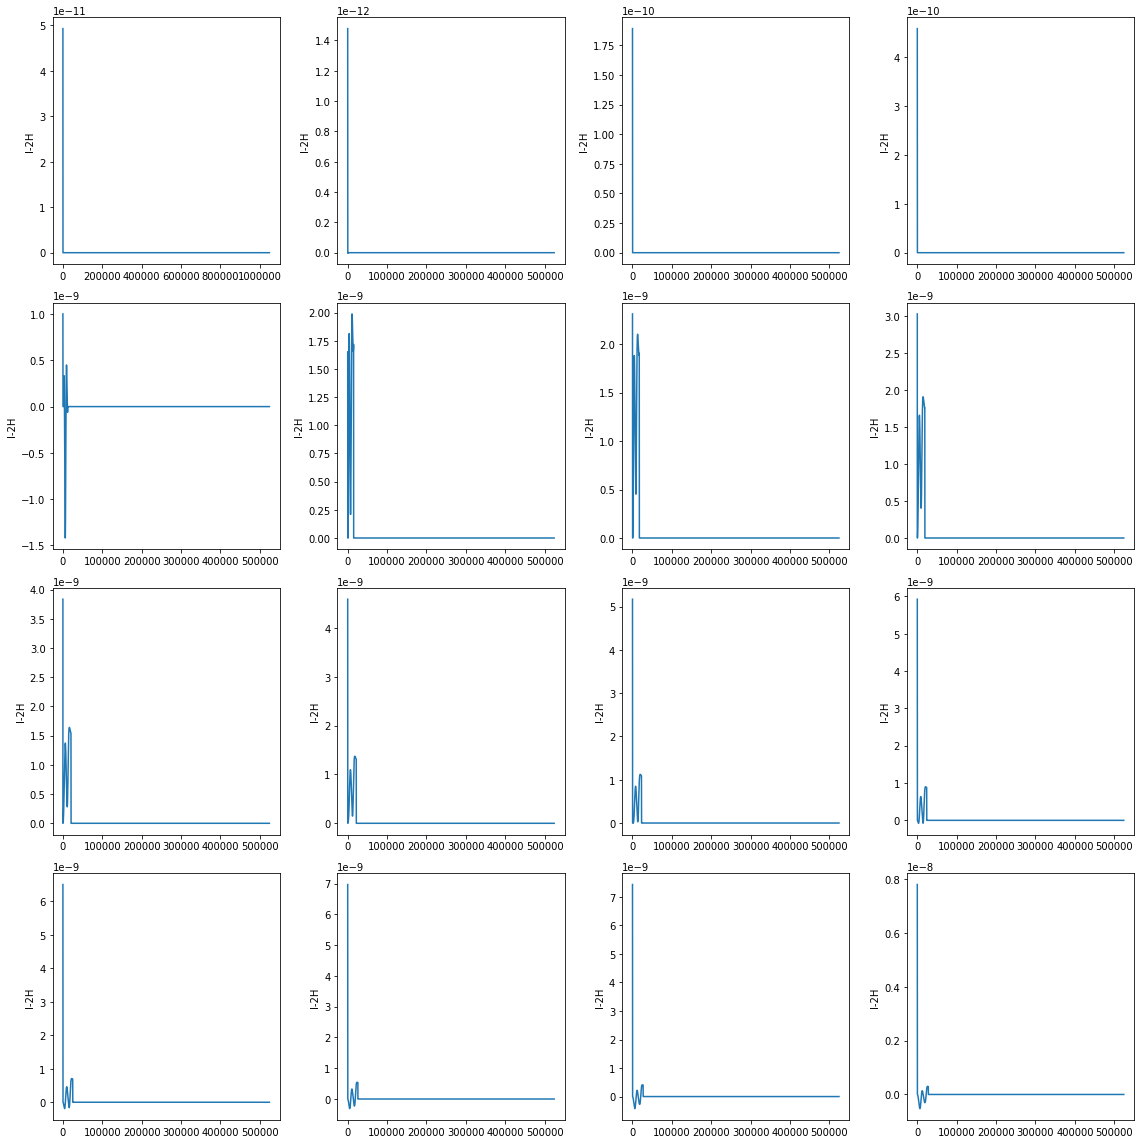

In [37]:
plt.figure(figsize=(16,16))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+i+1)
        plt.plot(data[4*j+i][5,:]-2*data[4*j+i][4,:])
        plt.ylabel('I-2H')
plt.tight_layout()

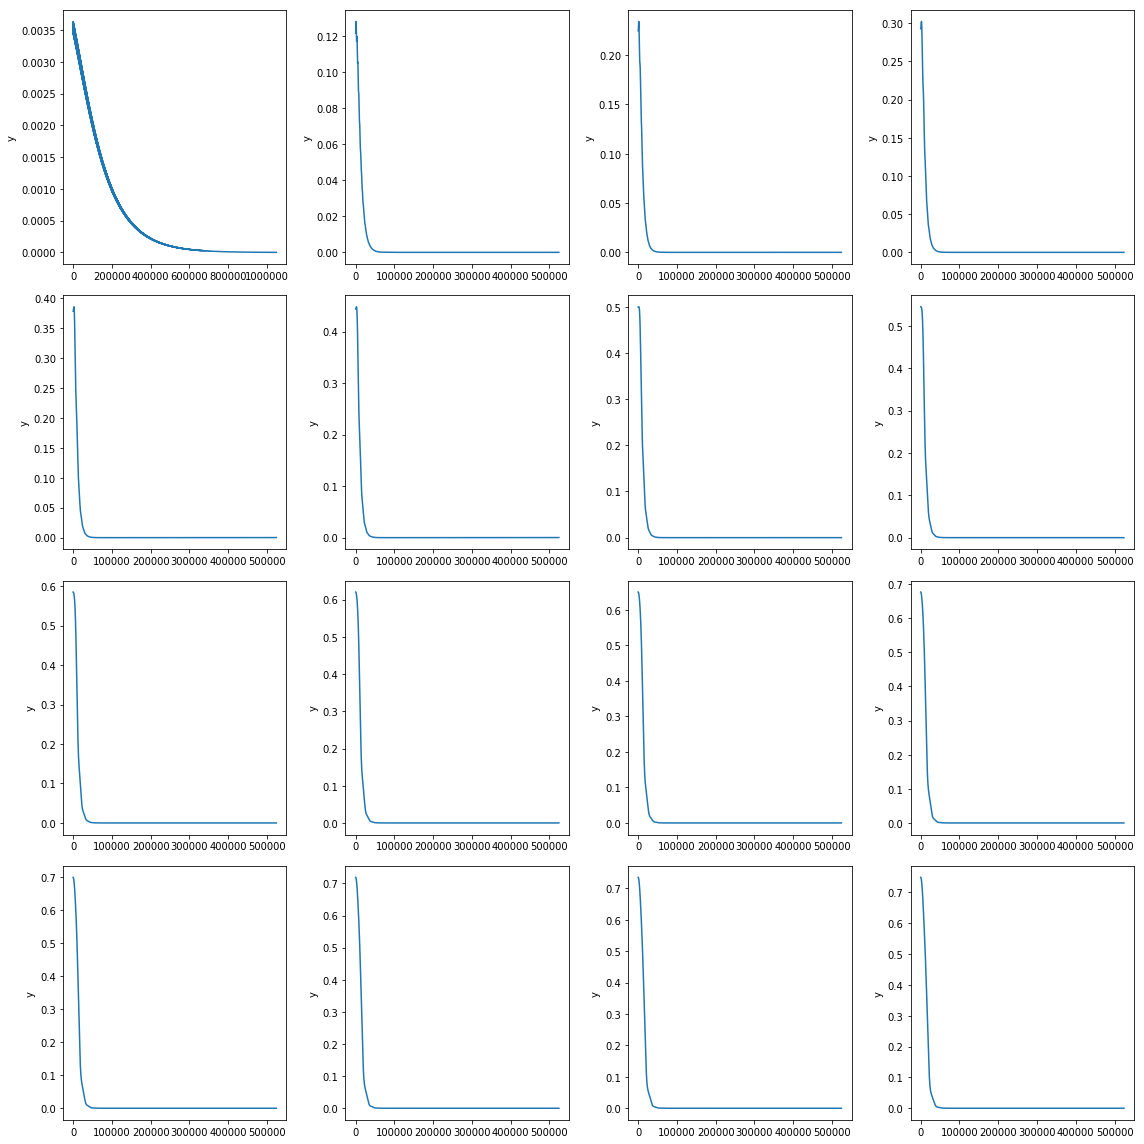

In [38]:
plt.figure(figsize=(16,16))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+i+1)
        plt.plot(data[4*j+i][2,:])
        plt.ylabel('y')
plt.tight_layout()

# Apply NAFF

In [39]:
from pImpactR.util import naff    

In [40]:
def isClose2resonant(nu0,nu1):
    for i in range(1,4):
        test = np.mod(nu0*i,1)
        if test*0.997 < nu1 < test*1.003:
            return True
        test = np.mod(nu0/i,1)
        if test*0.997 < nu1 < test*1.003:
            return True
    for i in range(-3,0):
        test = np.mod(nu0*i,1)
        if test*0.997 < nu1 < test*1.003:
            return True
        test = np.mod(nu0/i,1)
        if test*0.997 < nu1 < test*1.003:
            return True
    return False

def pick_non_resonant_tune(nu0,tunes):
    for i in range(len(tunes)):
        if not isClose2resonant(nu0,tunes[i]):
            return(tunes[i])
    return tunes[0]

In [41]:
data[0].shape

(6, 1048576)

In [42]:
tuneX = np.zeros(npt)
tuneY = np.zeros(npt)
for i in range(npt):
    signal = data[i][0,:] - 1j*data[i][1,:]
    signal = signal-np.mean(signal)
    tuneX[i] = impact.util.naff(1,signal)[0][0]
    signal = data[i][2,:] - 1j*data[i][3,:]
    signal = signal-np.mean(signal)
    tuneY[i] = impact.util.naff(1,signal)[0][0]

In [48]:
wX = np.zeros(npt)
for i in range(npt):
    wX[i] = tuneX[i]/Lrad*(i+1)*1024*1024*np.pi*2

In [49]:
tuneTheory = np.loadtxt('redArcFreq.TheoryFromXaxis.data')

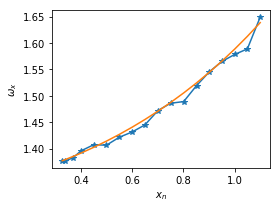

In [113]:
plt.figure(figsize=(4,3))
plt.plot(pdata[:,0],wX,'*-')
plt.plot(tuneTheory[:,0],tuneTheory[:,1])
plt.xlabel('$x_n$');
plt.ylabel(r'$\omega_x$');
plt.tight_layout()
plt.savefig('tune.onSeparatrix.png',dpi=180)

In [126]:
np.savetxt('wX.redArc.txt',wX)

In [122]:
surface_of_section = []
for item in data[1].T:
    if item[0]**2<1.0e-6:
        surface_of_section.append(item[2:4])
surface_of_section=np.array(surface_of_section)
surface_of_section.shape

(1003, 2)

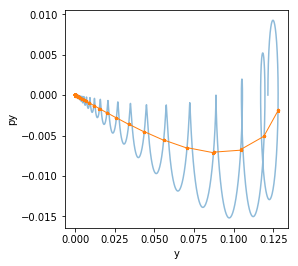

In [123]:
plt.figure(figsize=(4,4))
plt.plot(data[1][2,:],data[1][3,:],alpha=0.5)
plt.plot(surface_of_section[:,0],surface_of_section[:,1],'*-',markersize=3.0,lw=1.0)
plt.xlabel('y')
plt.ylabel('py')
plt.savefig('y-py.surf_sec.png',dpi=160)

In [124]:
np.savetxt('y-py.surf.section.txt',surface_of_section)

In [110]:
surface_of_section = []
for item in data[1].T:
    if item[2]**2<1.0e-36:
        surface_of_section.append(item[0:2])
surface_of_section=np.array(surface_of_section)
surface_of_section.shape

(21968, 2)

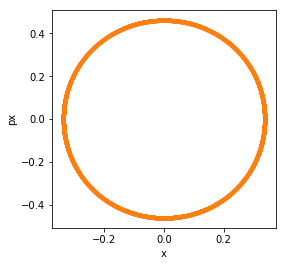

In [111]:
plt.figure(figsize=(4,4))
plt.plot(data[1][0,:],data[1][1,:],alpha=0.5)
plt.plot(surface_of_section[:,0],surface_of_section[:,1],'*-',markersize=3.0,lw=1.0)
plt.xlabel('x')
plt.ylabel('px')
plt.savefig('x-px.surf_sec.png',dpi=160)

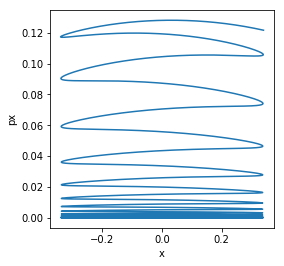

In [112]:
plt.figure(figsize=(4,4))
plt.plot(data[1][0,:],data[1][2,:])
plt.xlabel('x')
plt.ylabel('px')
plt.savefig('x-y.png',dpi=160)

In [114]:
Inv0[1]

[0.1061290318358909, 0.21225806367326]

In [125]:
list(data[1][[0,2],0])

[0.3400003898997519, 0.12157057272042504]

In [128]:
data[1].shape

(6, 524288)

In [130]:
524288/(1024*1024)*Lrad/2

512.0

In [132]:
524288/512

1024.0